# **Employee Attrition** 👷‍♀️👷‍♂️

`Objective:` The key to success in any organization is attracting and retaining top talent. I’m an HR analyst at my company, and one of my tasks is to determine which factors keep employees at my company and which prompt others to leave. I need to know what factors I can change to prevent the loss of good people. Watson Analytics is going to help.



In [175]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import Counter

In [176]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [177]:
df = df[['Attrition', 'Department', 'Gender', 'Age', 'EnvironmentSatisfaction', 'JobSatisfaction', 'MonthlyIncome', 'YearsAtCompany']]

In [178]:
def sampling(df, col, ratio=0.2):
    classes = np.unique(df[col])
    count = int(len(df) * ratio)
    indices = []
    for cls in classes:
        index = df[df[col] == cls].index.tolist()
        np.random.shuffle(index)
        indices.append(index[:count])
    return [index for index_list in indices for index in index_list]

indices = sampling(df, 'Attrition', ratio=0.1)
df = df.loc[indices]
df_clean = df.copy()

In [179]:
df.head()

,Attrition,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany
115,No,Sales,Male,37,3,4,7428,5
1429,No,Research & Development,Male,39,1,4,4108,7
1341,No,Research & Development,Male,31,2,3,4197,10
252,No,Research & Development,Male,29,3,4,2340,6
621,No,Sales,Male,36,2,4,6201,18


In [180]:
df.shape 

(294, 8)

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294 entries, 115 to 0
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Attrition                294 non-null    object
 1   Department               294 non-null    object
 2   Gender                   294 non-null    object
 3   Age                      294 non-null    int64 
 4   EnvironmentSatisfaction  294 non-null    int64 
 5   JobSatisfaction          294 non-null    int64 
 6   MonthlyIncome            294 non-null    int64 
 7   YearsAtCompany           294 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 20.7+ KB


In [182]:
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
Age,294.0,35.503401,9.839930,18.0,29.00,34.0,41.75,59.0
EnvironmentSatisfaction,294.0,2.554422,1.112494,1.0,2.00,3.0,3.00,4.0
JobSatisfaction,294.0,2.659864,1.147763,1.0,2.00,3.0,4.00,4.0
MonthlyIncome,294.0,5860.554422,4309.739923,1091.0,2611.25,4295.0,7654.75,19973.0
YearsAtCompany,294.0,6.047619,5.560506,0.0,2.00,5.0,9.00,37.0


In [183]:
df.describe(include='object').T

,count,unique,top,freq
Attrition,294,2,No,147
Department,294,3,Research & Development,186
Gender,294,2,Male,179


In [184]:
df_clean = df_clean.reset_index(drop=True)

In [185]:
def encoding(df, cols):
    for col in cols:
        df[col] = df[col].astype('category').cat.codes
    return df

object_cols = df_clean.select_dtypes(include='object')
df_clean = encoding(df_clean, object_cols)
df_clean.head()

,Attrition,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany
0,0,2,1,37,3,4,7428,5
1,0,1,1,39,1,4,4108,7
2,0,1,1,31,2,3,4197,10
3,0,1,1,29,3,4,2340,6
4,0,2,1,36,2,4,6201,18


In [186]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None, sample=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left 
        self.right = right
        self.info_gain = info_gain
        self.value = value 
        self.sample = sample 



class DecisionTreeClassifier:
    def __init__(self, max_depth=3, min_sample_split=2, min_sample_leaf=1, features=None, mode='gini'):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.min_sample_leaf = min_sample_leaf
        self.features = features
        self.mode = mode 

        self.root = None 
        self.feature_importance = None 


    """RECURSIBVE FUNC FOR BUILDING THE TREE"""
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape 

        features = np.arange(n_features)
        if self.features != None:
            features = self.features

        if n_samples>=self.min_sample_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, n_samples, features)

            if best_split['info_gain']>0 and len(best_split['dataset_left'])>=self.min_sample_leaf and len(best_split['dataset_right'])>=self.min_sample_leaf:
                feature_index = best_split['feature_index']

                self.feature_importance[0][feature_index] += best_split['info_gain']
                self.feature_importance[1][feature_index] += 1

                left_subtree = self.build_tree(best_split['dataset_left'], curr_depth+1)
                right_subtree = self.build_tree(best_split['dataset_right'], curr_depth+1)
                return Node(
                    feature_index=feature_index, threshold=best_split['threshold'], left=left_subtree, right=right_subtree, info_gain=best_split['info_gain'], sample=Y
                )
        
        leaf_value = self.calc_leaf_value(Y)
        return Node(value=leaf_value, sample=Y)
    
    def get_best_split(self, dataset, n_samples, features):
        best_split = {}
        max_info_gain = -float('inf')

        for feature_index in features:
            possible_thresholds = np.unique(dataset[:, feature_index])
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)

                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y, self.mode)

                    if curr_info_gain > max_info_gain:
                        best_split = {
                            "feature_index": feature_index,
                            "threshold": threshold,
                            "dataset_left": dataset_left,
                            "dataset_right": dataset_right,
                            "info_gain": curr_info_gain,
                        }
                        max_info_gain = curr_info_gain
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def calc_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    

    """INFORMATION GAIN"""
    def information_gain(self, parent, l_child, r_child, mode):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == 'gini':
            gain = self.gini(parent) - (weight_l*self.gini(l_child) + weight_r*self.gini(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        classes = np.unique(y)
        entropy = 0
        for cls in classes:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini(self, y):
        classes = np.unique(y)
        gini = 0
        for cls in classes:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1- gini
    


    """POST PRUNING"""
    def reduced_error_pruning(self, X_test, y_test, tree=None):
        if tree.left and tree.right:
            self.reduced_error_pruning(X_test, y_test, tree.left)
            self.reduced_error_pruning(X_test, y_test, tree.right)

            if tree.left.value != None and tree.right.value != None:
                accuracy_before = np.mean(self.predict(X_test) == y_test)
                tree.value = self.calc_leaf_value(y_test)
                accuracy_pruned = np.mean(self.predict(X_test) == y_test)

                if accuracy_pruned >= accuracy_before:
                    tree.left = None
                    tree.right = None 
                else:
                    tree.value = None 

    def _get_leaves(self, tree=None):
        if tree.value is not None:
            return [tree]
        return self._get_leaves(tree.left) + self._get_leaves(tree.right)    

    def _calc_subtree_cost(self, tree=None):
        if tree is None:
            return 0

        if tree.value is not None:
            y = np.array(tree.sample)
            if self.mode == 'gini':
                return self.gini(y)
            else:
                return self.entropy(y)

        left_cost = self._calc_subtree_cost(tree.left)
        right_cost = self._calc_subtree_cost(tree.right)   
        return left_cost + right_cost + 1

    def cost_complexity_pruning(self, alpha=0.01, tree=None):
        if tree is None:
            tree = self.root 

        if tree.left and tree.right:
            self.cost_complexity_pruning(alpha, tree.left)
            self.cost_complexity_pruning(alpha, tree.right)

            left_cost = self._calc_subtree_cost(tree.left)
            right_cost = self._calc_subtree_cost(tree.right)   

            if (left_cost + right_cost - 1) * alpha >= tree.info_gain:
                tree.value = self.calc_leaf_value([leaf.value for leaf in self._get_leaves(tree)])
                tree.left = tree.right = None 
        return tree



    """FIT AND PREDICT"""
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.feature_importance = np.zeros([2, X.shape[1]])
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions
    
    def make_predictions(self, x, tree=None):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)
        
    

    """PRINT TREE"""
    def print_tree(self, tree=None, depth=0):
        if tree is None:
            tree = self.root 

        if tree.value is not None:
            print(f'{'   ' * depth} leaf: {tree.value} | {dict(Counter(tree.sample))} | depth: {depth}')
            return
        
        print(f'{'   ' * depth} feature {tree.feature_index} <= {tree.threshold} | depth: {depth}')

        self.print_tree(tree.left, depth+1)
        self.print_tree(tree.right, depth+1)

    

    """LEAF INFO"""
    def get_leaf_all_info(self, tree=None, node_id=0, leaf_info=None):
        if leaf_info is None:
            leaf_info = {}

        if tree is None:
            tree = self.root 

        if tree.value is not None:
            count = Counter(tree.sample)
            ratio = {k: round(v / len(count), 2) for k, v in count.items()}
            leaf_info[node_id] = ratio
            return leaf_info
        
        self.get_leaf_all_info(tree.left, node_id * 2 +1, leaf_info)
        self.get_leaf_all_info(tree.right, node_id * 2 +2, leaf_info)
        return leaf_info
    
    def get_leaf_info(self, x, tree=None, node_id=0):
        if tree is None:
            tree = self.root 

        if tree.value is not None:
            count = Counter(tree.sample)
            ratio = {k: round(v / len(count), 2) for k, v in count.items()}
            return node_id, ratio
        
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.get_leaf_info(x, tree.left, node_id * 2 +1)
        else:
            return self.get_leaf_info(x, tree.right, node_id * 2 + 2)

In [ ]:
def accuracy_score(y_pred, y_test):
    return np.mean(y_pred == y_test) * 100

def cross_validation(X, y, model, k=5, pruning=False, alpha=0):
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    fold_size = n_samples // k
    accuracies = []

    for i in range(k):
        test_start = fold_size * i 
        test_end = test_start + fold_size if i < k - 1 else n_samples 
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        model.fit(X_train, y_train.reshape(-1, 1))
        if pruning == 'ccp':
            model.cost_complexity_pruning(alpha=alpha)
        elif pruning == 'rep':
            model.reduced_error_pruning(X_test, y_test, model.root)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_pred, y_test)
        accuracies.append(accuracy)

    data = {
        'X_train': X_train, 'X_test': X_test, 
        'y_train': y_train, 'y_test': y_test, 
        'y_pred': y_pred, 'test_indices': test_indices, 'train_indices': train_indices,
        'accuracies': accuracies
    }

    return data 

In [ ]:
model

In [188]:
attrition = df_clean['Attrition'].values
df_clean = df_clean.drop('Attrition', axis=1)
df_clean['Attrition'] = attrition
df_clean.head()

,Department,Gender,Age,EnvironmentSatisfaction,JobSatisfaction,MonthlyIncome,YearsAtCompany,Attrition
0,2,1,37,3,4,7428,5,0
1,1,1,39,1,4,4108,7,0
2,1,1,31,2,3,4197,10,0
3,1,1,29,3,4,2340,6,0
4,2,1,36,2,4,6201,18,0


In [189]:
X = df_clean.iloc[:, :-1].values
Y = df_clean.iloc[:, -1].values

## `Scenario 1`: Minimum Limitations

with gini VS with entropy

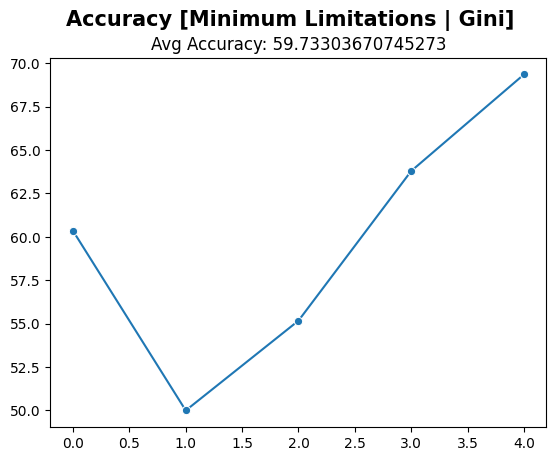

In [190]:
model_gini = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='gini')
data = cross_validation(X, Y, model_gini, k=5, pruning=False)
avg_accuracy = np.mean(data['accuracies'])
sns.lineplot(data['accuracies'], marker='o')
plt.suptitle('Accuracy [Minimum Limitations | Gini]', size=15, weight='bold')
plt.title(f'Avg Accuracy: {avg_accuracy}')
plt.show()

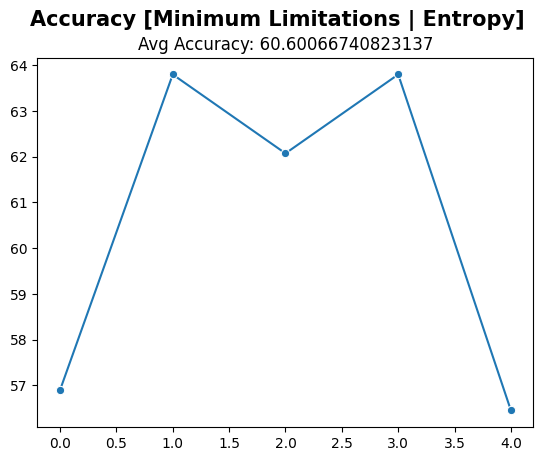

In [191]:
model_entropy = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=None, mode='entropy')
data = cross_validation(X, Y, model_entropy, k=5, pruning=False)
avg_accuracy = np.mean(data['accuracies'])
sns.lineplot(data['accuracies'], marker='o')
plt.suptitle('Accuracy [Minimum Limitations | Entropy]', size=15, weight='bold')
plt.title(f'Avg Accuracy: {avg_accuracy}')
plt.show()

they almost perform the same, let's check on their leave nodes

In [192]:
for k, v in model_gini.get_leaf_all_info().items():
    print(f'Node id: {k}, value: {v}')

Node id: 7, value: {1: 30.0}
Node id: 71, value: {1: 1.0}
Node id: 291, value: {0: 4.0}
Node id: 585, value: {0: 1.0}
Node id: 1173, value: {1: 1.0}
Node id: 1174, value: {0: 1.0}
Node id: 146, value: {1: 1.0}
Node id: 73, value: {0: 1.0}
Node id: 74, value: {1: 5.0}
Node id: 75, value: {1: 8.0}
Node id: 153, value: {1: 3.0}
Node id: 309, value: {0: 2.0}
Node id: 310, value: {1: 1.0}
Node id: 38, value: {0: 1.0}
Node id: 39, value: {1: 1.0}
Node id: 40, value: {0: 2.0}
Node id: 41, value: {1: 8.0}
Node id: 42, value: {0: 1.0}
Node id: 87, value: {1: 2.0}
Node id: 711, value: {1: 1.0}
Node id: 712, value: {0: 1.0}
Node id: 356, value: {1: 2.0}
Node id: 715, value: {0: 1.0}
Node id: 716, value: {1: 1.0}
Node id: 358, value: {0: 5.0}
Node id: 44, value: {1: 5.0}
Node id: 91, value: {0: 8.0}
Node id: 185, value: {1: 1.0}
Node id: 186, value: {0: 2.0}
Node id: 93, value: {1: 2.0}
Node id: 189, value: {0: 3.0}
Node id: 381, value: {1: 3.0}
Node id: 765, value: {0: 4.0}
Node id: 766, value: {

In [193]:
key_0 = [pair.get(0) for pair in model_gini.get_leaf_all_info().values() if pair.get(0) is not None]
key_1 = [pair.get(1) for pair in model_gini.get_leaf_all_info().values() if pair.get(1) is not None]
print('==GINI==')
print(f'Nodes with 0 class {len(key_0)}')
print(f'Nodes with 1 class {len(key_1)}')

==GINI==
Nodes with 0 class 32
Nodes with 1 class 34


In [194]:
key_0 = [pair.get(0) for pair in model_entropy.get_leaf_all_info().values() if pair.get(0) is not None]
key_1 = [pair.get(1) for pair in model_entropy.get_leaf_all_info().values() if pair.get(1) is not None]
print('==ENTROPY==')
print(f'Nodes with 0 class {len(key_0)}')
print(f'Nodes with 1 class {len(key_1)}')

==ENTROPY==
Nodes with 0 class 37
Nodes with 1 class 33


entropy tend to evenly distribute the underrated class

## `Scenario 2`: Pre Pruning

In [195]:
from itertools import product

max_depths = [5, 15]
min_sample_splits = [5, 10]
min_sample_leaves = [1, 3]
features = [None, [4, 5]]
modes = ['gini', 'entropy']

param_combinitions = list(product(max_depths, min_sample_splits, min_sample_leaves, features, modes))
print(f'Total combinitions: {len(param_combinitions)}')

Total combinitions: 32


In [196]:
accuracies = []
for param in param_combinitions:
    model = DecisionTreeClassifier(max_depth=param[0], min_sample_split=param[1], min_sample_leaf=param[2], features=param[3], mode=param[4])
    data = cross_validation(X, Y, model_entropy, k=5, pruning=False)
    avg_accuracy = np.mean(data['accuracies'])
    accuracies.append(avg_accuracy)
indices = np.argsort(accuracies)[::-1]
top_3 = np.array(accuracies)[indices[:3]]
param_top_3 = [param_combinitions[i] for i in indices[:3]] 
least_3 = np.array(accuracies)[indices[-3:]]
param_least_3 = [param_combinitions[i] for i in indices[3:]] 

In [197]:
print(f'Top 3: {top_3}')
print(f'Param: {param_top_3}')

Top 3: [63.29254727 62.66963293 62.55839822]
Param: [(5, 5, 3, [4, 5], 'entropy'), (5, 10, 1, [4, 5], 'gini'), (15, 10, 1, None, 'entropy')]


In [198]:
print(f'Least 3: {least_3}')
print(f'Param: {param_least_3}')

Least 3: [56.74082314 55.70634038 54.50500556]
Param: [(15, 5, 1, [4, 5], 'entropy'), (15, 5, 3, None, 'entropy'), (5, 5, 1, None, 'gini'), (15, 10, 3, [4, 5], 'gini'), (15, 10, 1, [4, 5], 'entropy'), (5, 5, 1, [4, 5], 'entropy'), (5, 10, 3, [4, 5], 'entropy'), (15, 10, 3, [4, 5], 'entropy'), (15, 10, 3, None, 'gini'), (5, 5, 1, [4, 5], 'gini'), (15, 5, 1, [4, 5], 'gini'), (5, 10, 1, None, 'gini'), (5, 10, 1, None, 'entropy'), (5, 5, 3, None, 'gini'), (5, 10, 3, None, 'gini'), (5, 5, 3, None, 'entropy'), (15, 5, 1, None, 'gini'), (5, 5, 1, None, 'entropy'), (5, 10, 3, None, 'entropy'), (15, 5, 1, None, 'entropy'), (15, 5, 3, [4, 5], 'gini'), (15, 5, 3, [4, 5], 'entropy'), (15, 10, 3, None, 'entropy'), (5, 10, 1, [4, 5], 'entropy'), (15, 10, 1, [4, 5], 'gini'), (15, 5, 3, None, 'gini'), (5, 5, 3, [4, 5], 'gini'), (5, 10, 3, [4, 5], 'gini'), (15, 10, 1, None, 'gini')]


## `Scenario 3`: Post Pruning Cost Complexity

In [200]:
model = DecisionTreeClassifier(max_depth=float('inf'), min_sample_split=2, min_sample_leaf=1, features=param[3], mode=param[4])
data = cross_validation(X, Y, model_entropy, k=5, pruning='ccp')
model.print_tree()

AttributeError: 'NoneType' object has no attribute 'value'

In [202]:
data['accuracies']

[62.06896551724138,
 56.896551724137936,
 65.51724137931035,
 51.724137931034484,
 56.451612903225815]

## `Scenario 4`: Post Pruning Reduced Error 

## `Scenario 2`: Pre Pruning